# Imports

In [1]:
import time
import os
import copy

import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.metrics import accuracy_score

%matplotlib inline  
import matplotlib.pyplot as plt

# Gather data

In [2]:
# Download image data of bees and ants.
! wget https://download.pytorch.org/tutorial/hymenoptera_data.zip

--2020-09-18 20:46:30--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 54.192.86.106, 54.192.86.77, 54.192.86.125, ...
Connecting to download.pytorch.org (download.pytorch.org)|54.192.86.106|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M  13.3MB/s    in 3.4s    

2020-09-18 20:46:33 (13.3 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]



In [3]:
# unzip the data.
! unzip hymenoptera_data.zip

Archive:  hymenoptera_data.zip
   creating: hymenoptera_data/
   creating: hymenoptera_data/train/
   creating: hymenoptera_data/train/ants/
  inflating: hymenoptera_data/train/ants/0013035.jpg  
  inflating: hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg  
  inflating: hymenoptera_data/train/ants/1095476100_3906d8afde.jpg  
  inflating: hymenoptera_data/train/ants/1099452230_d1949d3250.jpg  
  inflating: hymenoptera_data/train/ants/116570827_e9c126745d.jpg  
  inflating: hymenoptera_data/train/ants/1225872729_6f0856588f.jpg  
  inflating: hymenoptera_data/train/ants/1262877379_64fcada201.jpg  
  inflating: hymenoptera_data/train/ants/1269756697_0bce92cdab.jpg  
  inflating: hymenoptera_data/train/ants/1286984635_5119e80de1.jpg  
  inflating: hymenoptera_data/train/ants/132478121_2a430adea2.jpg  
  inflating: hymenoptera_data/train/ants/1360291657_dc248c5eea.jpg  
  inflating: hymenoptera_data/train/ants/1368913450_e146e2fb6d.jpg  
  inflating: hymenoptera_data/train/ants/147318

# Pre-process the data

In [4]:
PATH = 'hymenoptera_data'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'val')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

Found 245 files belonging to 2 classes.
Found 153 files belonging to 2 classes.


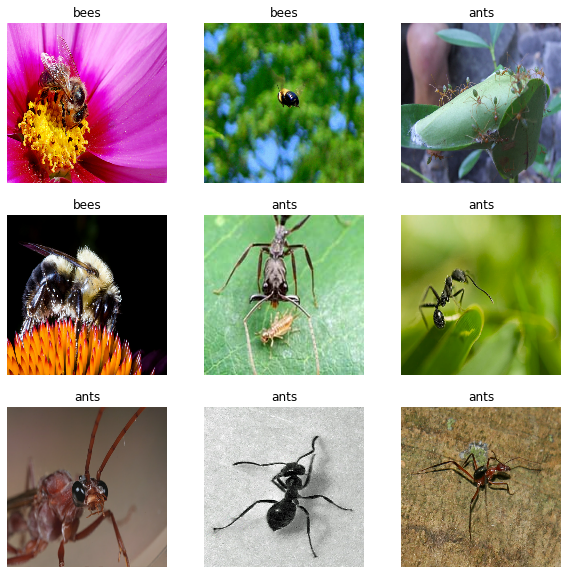

In [5]:
# Take a look at some of our images and the corresponding labels.
class_names = train_dataset.class_names
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [6]:
# Create a test set in addition to the validation set
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 4
Number of test batches: 1


# Load the pre-trained model and create a classification head

In [7]:
# Load the pre-trained MobileNet V2 without the classification head
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9412608/9406464 [==============================] - 0s 0us/step


In [8]:
# "freeze" the convolutional, feature extraction parameters.
base_model.trainable = False

In [9]:
# Create a data augmentation layer because of our small data set size.
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

# Create a rescaling layer because the MobileNet model expects pixel vaues in a  
# range of [-1,1], but our values are in teh rannge [0,255].
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

# Create a classification head for our model
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(1)

In [10]:
# Put everything together using the keras functional API
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = rescale(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [11]:
# Prep the model for training and set training parameters.
learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Train the model (using transfer learning)

In [12]:
epochs = 50
history = model.fit(train_dataset,
                    epochs=epochs,
                    validation_data=validation_dataset)

Epoch 1/50
8/8 [==============================] - 2s 195ms/step - loss: 0.8284 - accuracy: 0.4939 - val_loss: 0.8332 - val_accuracy: 0.4298
Epoch 2/50
8/8 [==============================] - 1s 88ms/step - loss: 0.7894 - accuracy: 0.5673 - val_loss: 0.7217 - val_accuracy: 0.4793
Epoch 3/50
8/8 [==============================] - 1s 91ms/step - loss: 0.7635 - accuracy: 0.5306 - val_loss: 0.7025 - val_accuracy: 0.5124
Epoch 4/50
8/8 [==============================] - 1s 91ms/step - loss: 0.6918 - accuracy: 0.5429 - val_loss: 0.6985 - val_accuracy: 0.4959
Epoch 5/50
8/8 [==============================] - 1s 92ms/step - loss: 0.6699 - accuracy: 0.6122 - val_loss: 0.6373 - val_accuracy: 0.5455
Epoch 6/50
8/8 [==============================] - 1s 88ms/step - loss: 0.6624 - accuracy: 0.6163 - val_loss: 0.6257 - val_accuracy: 0.5868
Epoch 7/50
8/8 [==============================] - 1s 90ms/step - loss: 0.6399 - accuracy: 0.6245 - val_loss: 0.5966 - val_accuracy: 0.6116
Epoch 8/50
8/8 [==========

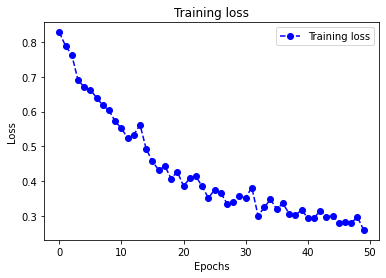

In [13]:
# Plot the training loss for each epoch to see how the model converged.
history_dict = history.history
plt.plot(list(range(0,epochs)), history_dict['loss'], 'bo--', label='Training loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Evaluate the transfer learned model

In [14]:
# Evaluate the model on the test set. 
test_loss, test_acc = model.evaluate(test_dataset, 
          verbose=2)

print('\nTest accuracy:', test_acc)

1/1 - 0s - loss: 0.2455 - accuracy: 0.9062

Test accuracy: 0.90625


# Update the training to "fine-tune" the base model

In [15]:
# Reset the base model to be "trainable"
base_model.trainable = True

In [17]:
# Print the number of layers in the base model
len(base_model.layers)

155

In [19]:
# Let's keep 100 of these layers frozen, and fine-tune the rest.
for layer in base_model.layers[:100]:
  layer.trainable =  False

In [20]:
# Prep the model for re-training. This time with a smaller learning rate.
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=learning_rate/10),
              metrics=['accuracy'])

# Fine tune the model 

In [21]:
ft_epochs =  epochs + 50
history_ft = model.fit(train_dataset,
                         epochs=ft_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 50/100
8/8 [==============================] - 2s 189ms/step - loss: 0.2373 - accuracy: 0.9020 - val_loss: 0.1945 - val_accuracy: 0.9339
Epoch 51/100
8/8 [==============================] - 1s 95ms/step - loss: 0.1898 - accuracy: 0.9306 - val_loss: 0.1844 - val_accuracy: 0.9421
Epoch 52/100
8/8 [==============================] - 1s 94ms/step - loss: 0.1818 - accuracy: 0.9184 - val_loss: 0.1780 - val_accuracy: 0.9421
Epoch 53/100
8/8 [==============================] - 1s 96ms/step - loss: 0.1337 - accuracy: 0.9551 - val_loss: 0.1660 - val_accuracy: 0.9421
Epoch 54/100
8/8 [==============================] - 1s 96ms/step - loss: 0.1101 - accuracy: 0.9592 - val_loss: 0.1828 - val_accuracy: 0.9174
Epoch 55/100
8/8 [==============================] - 1s 94ms/step - loss: 0.1261 - accuracy: 0.9633 - val_loss: 0.1860 - val_accuracy: 0.9339
Epoch 56/100
8/8 [==============================] - 1s 97ms/step - loss: 0.1160 - accuracy: 0.9510 - val_loss: 0.1595 - val_accuracy: 0.9339
Epoch 57/100

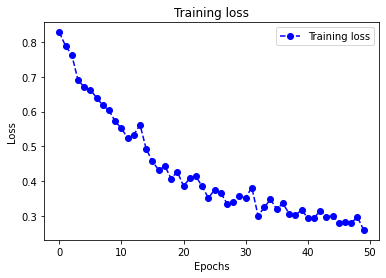

In [23]:
# Plot the training loss for each epoch to see how the model converged.
history_dict = history.history
plt.plot(list(range(0,ft_epochs - epochs)), history_dict['loss'], 'bo--', label='Training loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Evaluate the fine-tuned model

In [24]:
# Evaluate the model on the test set. 
test_loss, test_acc = model.evaluate(test_dataset, 
          verbose=2)

print('\nTest accuracy:', test_acc)

1/1 - 0s - loss: 0.2624 - accuracy: 0.9375

Test accuracy: 0.9375
